# WINDNODE ABW - Scenario Analysis

<img src="http://reiner-lemoine-institut.de//wp-content/uploads/2015/09/rlilogo.png" width="100" style="float: right">

__copyright__ 	= "© Reiner Lemoine Institut" <br>
__license__ 	= "GNU Affero General Public License Version 3 (AGPL-3.0)" <br>
__url__ 		= "https://www.gnu.org/licenses/agpl-3.0.en.html" <br>
__author__ 		= "Julian Endres" <br>

In [89]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
######## WINDNODE ###########
# define and setup logger
from windnode_abw.tools.logger import setup_logger
logger = setup_logger()

# load configs
from windnode_abw.tools import config
config.load_config('config_data.cfg')
config.load_config('config_misc.cfg')

from windnode_abw.analysis import analysis
from windnode_abw.tools.draw import *
######## DATA ###########

import re
import pandas as pd

######## PostgreSQL ###########
import sys
import os
import getpass
from sqlalchemy import *

######## Plotting ###########

# Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

# set seaborn style
sns.set()

import plotly.express as px
import plotly.io as pio
import plotly.graph_objs as go
import plotly.offline as pltly

In [2]:
# specify what to import (in path ~/.windnode_abw/)
run_timestamp = '2020-06-30_222735_1month'
# select multiple scenarios manually or use 'ALL' to analyze all
# scenarios found in directory
#scenarios = [scenario, 'sq']
#scenarios = ['ALL']
scenarios = ['NEP2035','NEP2035_AUT80','NEP2035_DSMhigh']

regions_scns, results_scns = analysis(run_timestamp=run_timestamp,
                   scenarios=scenarios)


23:25:54-INFO: Analyzing 3 scenarios...
23:25:54-INFO: -> Analyzing scenario: NEP2035...
23:25:55-INFO: Importing municipalities...
23:25:56-INFO: Importing demography...
23:25:56-INFO: Importing demand timeseries...
23:26:01-INFO: Importing feedin timeseries...
23:26:08-INFO: Importing DSM timeseries...
23:26:15-INFO: Importing temperature timeseries...
23:26:17-INFO: Importing HV grid...
23:26:18-INFO: Importing generators...
23:26:18-INFO: Importing heating structure...
23:26:18-INFO: Importing technical assumptions...
23:26:18-INFO: Importing RE potential areas...
23:26:51-INFO: -> Analyzing scenario: NEP2035_AUT80...
23:26:52-INFO: Importing municipalities...
23:26:53-INFO: Importing demography...
23:26:53-INFO: Importing demand timeseries...
23:26:57-INFO: Importing feedin timeseries...
23:27:03-INFO: Importing DSM timeseries...
23:27:09-INFO: Importing temperature timeseries...
23:27:11-INFO: Importing HV grid...
23:27:12-INFO: Importing generators...
23:27:12-INFO: Importing he

# TODO
- [ ] parallelize analysis
- [ ] save / pickle results

In [3]:
scenario = scenarios[0]
period = run_timestamp.split('_')[-1]

In [4]:
MUN_NAMES = regions_scns[scenario].muns.gen.to_dict()

In [162]:
UNITS = {
    'Grid losses': 'MWh',
    'Electricity demand': 'MWh',
    'Electricity demand for heating': 'MWh',
    'Electricity demand total': 'MWh',
    'Heating demand': 'MWh',
    'Electricity imports': 'MWh',
    'Electricity exports': 'MWh',
    'Electricity imports % of demand': '%',
    'Electricity exports % of demand': '%',
    'Balance': 'MWh',
    'Self-consumption annual': 'MWh',
    'Self-consumption hourly': 'MWh',
    'Area required pv_roof_small': 'ha',
    'Area required pv_roof_large': 'ha',
    'Area required pv_ground': 'ha',
    'Area required wind': 'ha',
    'CO2 emissions el.': 'tCO2',
    'CO2 emissions th.': 'tCO2',
    'Net DSM activation': 'MWh',
    "Electricity storage losses": "MWh",
    "Heat storage losses": "MWh",
    "Area required rel. PV rooftop": "%",
    "Area required rel. PV ground hard": "%",
    "Area required rel. PV ground hard soft": "%",
    "Area required rel. PV ground hard 1-perc agri": "%",
    "Area required rel. PV ground hard soft 1-perc agri": "%",
    "Area required rel. wind 500m wo forest": "%",
    "Area required rel. wind 500m w forest": "%",
    "Area required rel. wind 1000m w forest": "%",
}

In [163]:
PRINT_NAMES = {
    'bhkw': "Large-scale CHP",
    'bio': "Biogas",
    'gas': "Open-cycle gas turbine",
    'gud': "Combined-cycle gas turbine",
    'bhkw': 'CHP',
    'hydro': "Hydro",
    'pv_ground': "PV ground-mounted",
    'pv_roof_large': "PV roof top (large)",
    'pv_roof_small': "PV roof top (small)",
    'wind': "Wind",
    'import': "Electricity imports (national grid)",
    "elenergy": "Direct electric heating",
    "fuel_oil": "Oil heating",
    "gas_boiler": "Gas (district heating)",
    "natural_gas": "Gas heating",
    "solar": "Solar thermal heating",
    "wood": "Wood heating",
    "coal": "Coal heating",
    "pth": "Power-to-heat (district heating)",
    "pth_ASHP" : "Air source heat pump",
    "pth_GSHP" : "Ground source heat pump",
    "stor_th_large" : "Thermal storage (district heating)",
    "stor_th_small" : "Thermal storage",
    "flex_bat_large" : "Large-scale battery storage",
    "flex_bat_small" : "PV system battery storage",
    "hh" : "Households",
    "ind" : "Industry",
    "rca" : "Agri-comerce",
    "export" : "Export",
    "conventional" : "Conventional",
    "el_hh" : "Electricity households",
    "el_rca" : "Electricity agri-comerce",
    "el_ind" : "Electricity industry"
}

# https://developer.mozilla.org/en-US/docs/Web/CSS/color_value
# https://plotly.com/python/builtin-colorscales/
COLORS = {'bio': 'green',
          'hydro': 'royalblue',
          'pv_ground' : 'goldenrod',
          'pv_roof_large' : 'gold',
          'pv_roof_small' : 'darkorange',
          'wind': 'skyblue',
          'conventional':'grey',
          'gud':'teal',
          'bhkw' : 'seagreen',
          'gas' : 'lightgrey',
          'import' : 'maroon',
          'export' : 'olive',
          'demand' : 'darkgray',
          'rca': 'gray',
          'hh': 'darkmagenta',
          'ind': 'darkslategray',
          'el_rca': 'gray',
          'el_hh': 'darkmagenta',
          'el_ind': 'darkslategray'
         }

Ganz ABW mit Barplot?

# 3 Area required
- [x] relativ
- [x] absolut

# relative 
- zero values at pv ground -> city

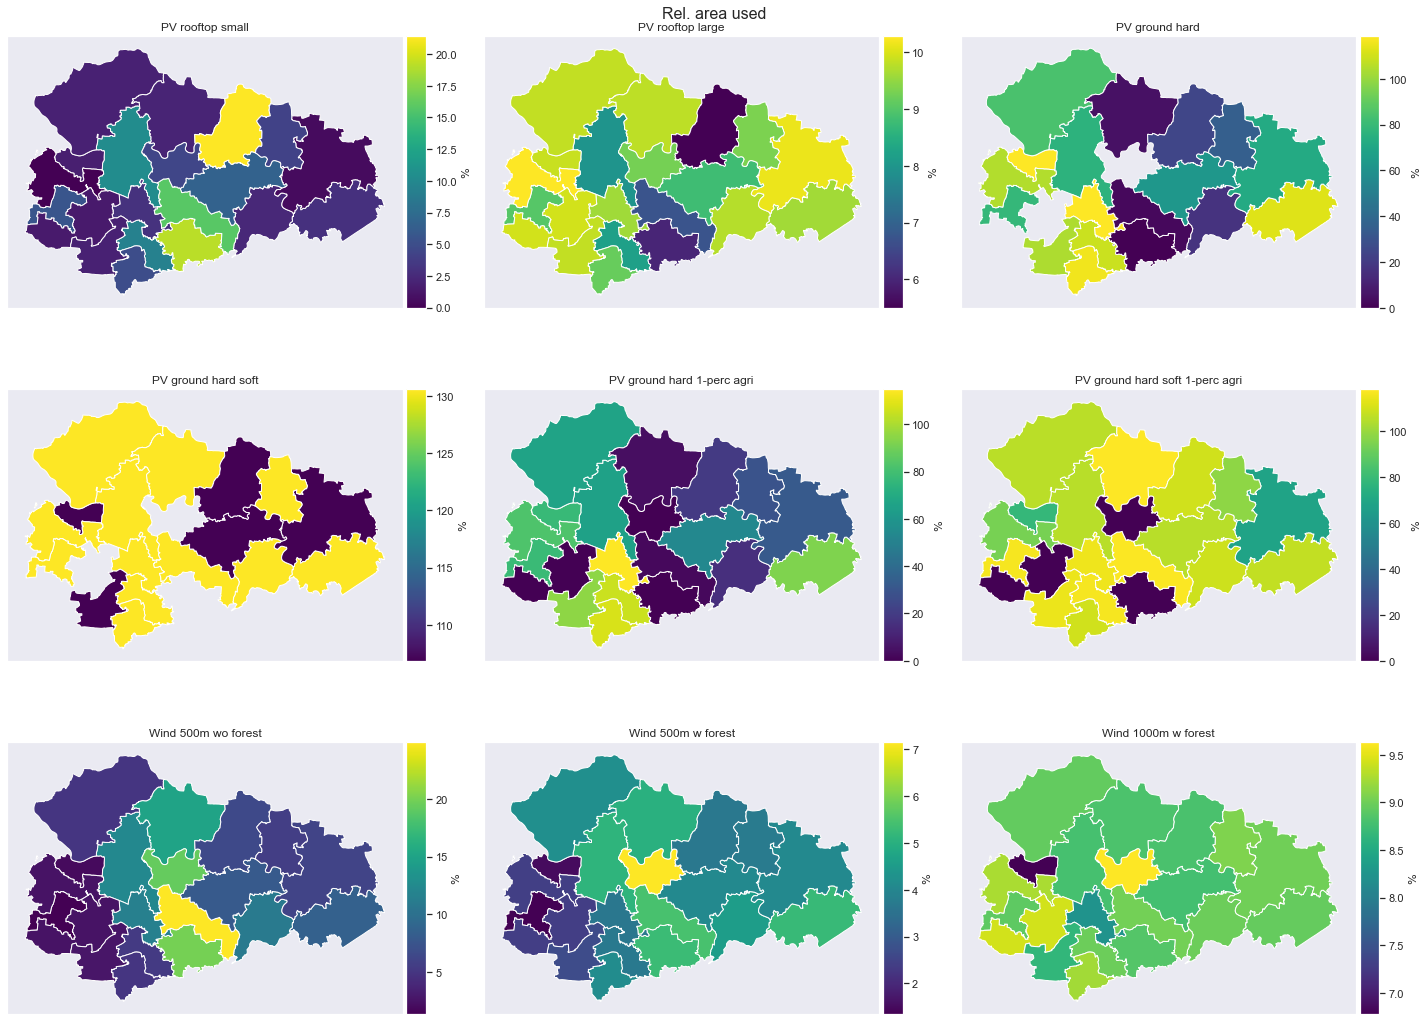

In [8]:
plot_kwds  = {
    'nrows': 3,
    'ncols': 3,
    'figsize': (20,15),
    'title': 'Rel. area used',
    'legend_label': '%',
    'cmap' :'viridis'
}

plot_geoplots(regions_scns[scenario],
              results_scns[scenario]['results_axlxt']['Area required rel.'],
              plot_kwds)

## absolute

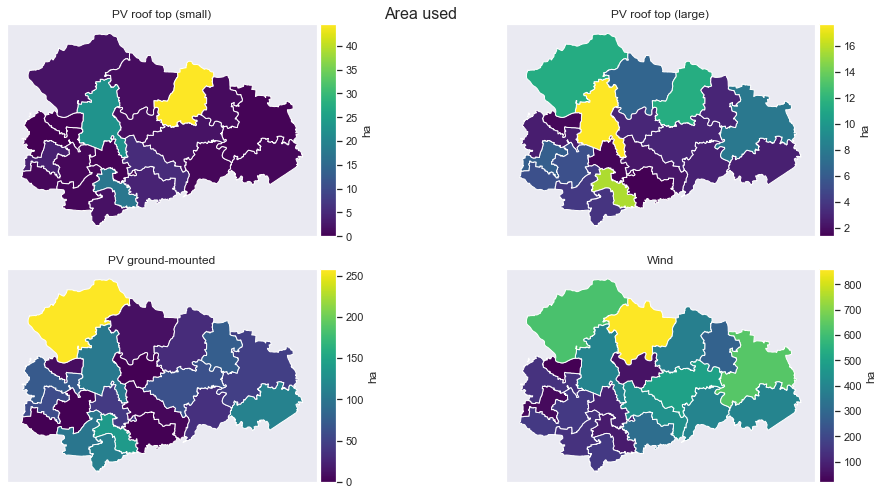

In [13]:
plot_kwds  = {
    'nrows': 2,
    'ncols': 2,
    'figsize': (15,7),
    'title': 'Area used',
    'legend_label': 'ha',
    'cmap' :'viridis'
}

region = regions_scns[scenario]
plot_geoplots(regions_scns[scenario],
              results_scns[scenario]['results_axlxt']['Area required'],
              plot_kwds)

## 4,5 Eigenversorgungsanteil

- [x] Absolut (Bilanz Jahresmenge) 2bars supply/demand
- [x] relativ in Prozent
- [ ] histogramm timeseries
- [ ] boxplots timeseries (prozentual Energiebilanz)

## timeseries

In [16]:
# Autarky timeseries
df_autarky_ts = pd.DataFrame()
df_autarky_ts['supply'] = results_scns[scenario]['flows_txaxt']['Stromerzeugung'].drop(columns='import').sum(axis=1)
df_autarky_ts['demand'] = results_scns[scenario]['flows_txaxt']['Stromnachfrage'].drop(columns='export').sum(axis=1)
df_autarky_ts['absolute'] = df_autarky_ts['supply'].unstack().subtract(df_autarky_ts['demand'].unstack()).stack()
df_autarky_ts['relative'] = df_autarky_ts['supply'].unstack().div(df_autarky_ts['demand'].unstack()).stack()

## sum of year / month

In [18]:
# Autarky sum of year/month
df_autarky = pd.DataFrame()
df_autarky['supply'] = df_autarky_ts['supply'].sum(level=1)
df_autarky['demand'] = df_autarky_ts['demand'].sum(level=1)
df_autarky['relative'] = df_autarky['supply'].div(df_autarky['demand'])
df_autarky['hours'] = (df_autarky_ts['relative']>1).sum(level=1).astype(int)
df_autarky['hours max'] = len(df_autarky_ts['relative'].index.get_level_values(level=0).unique())

# correct index to int
df_autarky.index = df_autarky.index.astype(int)

- log scale is confusing
- without log difficult

## absolute

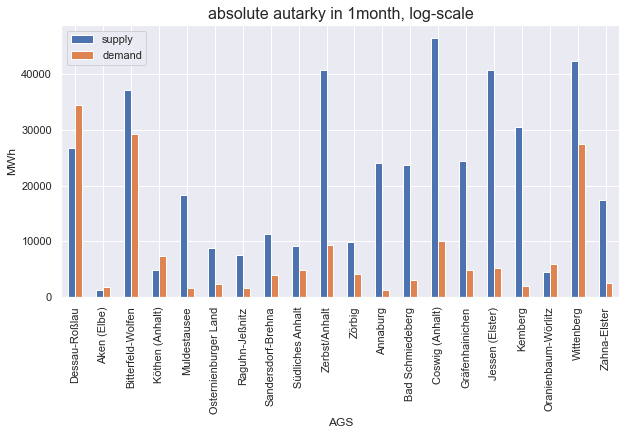

In [55]:
fig, ax = plt.subplots(figsize=(10,5))

df_data = df_autarky.loc[:,['supply','demand']].rename(index=MUN_NAMES)

#colors = colors_hight(df_data.values, 'BuGn_r')
df_data.plot(kind='bar', ax=ax)#, color=['r','b'])
ax.set_xlabel('AGS')
ax.set_ylabel('MWh')
ax.set_title('absolute autarky in {}, log-scale'.format(period),
              fontsize=16,
              fontweight='normal')
# log scaler
#ax.set_yscale('log')
#ax.set_yticks([10,20,30,40,50,60,70,80,100,300,500,1000])
#ax.set_yticks([100,500, 1000,5000,10000, 50000])
#ax.yaxis.set_major_formatter(ScalarFormatter())

plt.show()

## relative per month

In [43]:
def plot_autarky(df_data, limit, MUN_NAMES):
    
    df_data = df_data.mul(100).rename(index=MUN_NAMES)

    df_data_left = df_data[df_data < limit]
    df_data_right = df_data[df_data >= limit]

    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
    fig.suptitle('rel. autarky in {}'.format(period),
                 fontsize=16,
                 fontweight='normal')

    # left plot
    df_data_left.plot(kind='bar', ax=ax1)#, color=colors_hight(df_data_left.values, 'winter'))
    ax1.set_xlabel('AGS')
    ax1.set_ylabel('%')
    ax1.set_ylim([0,150])

    # right plot
    # all in log scale
    #ax2.set_title('log-scale', fontsize=12, fontweight='normal')

    df_data_right.plot(kind='bar', ax=ax2)#, color=colors_hight(df_data_right.values, 'winter'))
    ax2.set_xlabel('AGS')
    ax2.set_ylabel('%')

    plt.show()

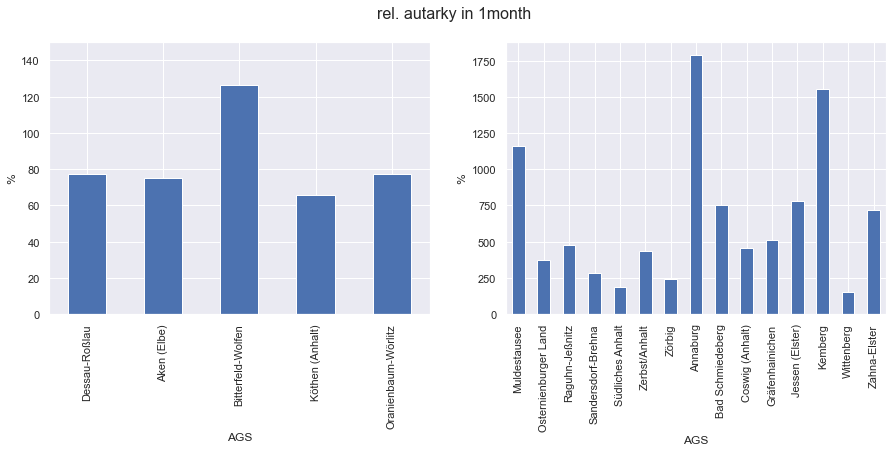

In [45]:
plot_autarky(df_autarky['relative'], 150, MUN_NAMES)

## relative time

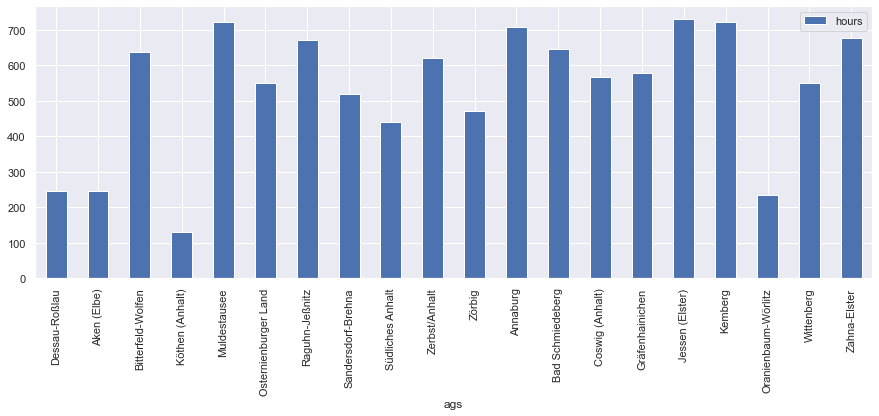

In [81]:
df_data = df_autarky.loc[:,['hours']]

df_data = df_data.rename(index=MUN_NAMES)
fig, ax = plt.subplots(1, figsize=(15,5))

df_data.plot(kind='bar', ax=ax)

- rechter Plot müsste eigentlich eine Prozentscala haben

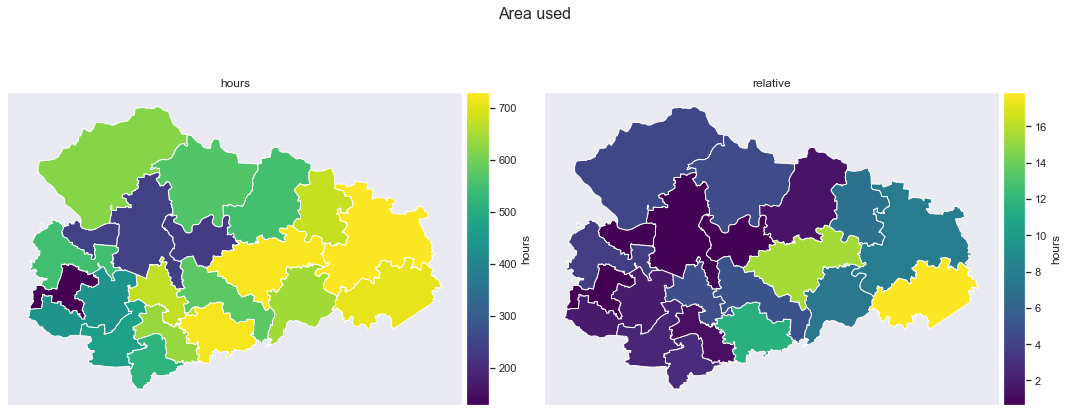

In [78]:
plot_kwds  = {
    'nrows': 1,
    'ncols': 2,
    'figsize': (15,7),
    'title': 'Autarky',
    'legend_label': 'hours',
    'cmap' :'viridis'
}

region = regions_scns[scenario]
plot_geoplots(regions_scns[scenario],
              df_autarky.loc[:,['hours', 'relative']],
              plot_kwds)

TODO
- [ ] Summe über alle Gemeinde als TS zusätzlich?
- [ ] relativer Zeitliche Anteil Autarky 10% aller stunden
- [x] geoplot

# 6 Energymix

In [20]:
results_scns[scenario]['flows_txaxt']['Stromexport']

level                                ehv         hv
timestamp           ags                            
2015-01-01 00:00:00 15082340    0.000000   0.000000
                    15082256    0.000000   0.000000
                    15082430    0.000000   0.000000
                    15091010    0.000000   0.000000
                    15091145    0.000000   0.000000
...                                  ...        ...
2015-01-31 23:00:00 15091010    0.000000  69.116190
                    15091145  154.300805   0.000000
                    15082377    0.000000  23.093754
                    15082301  435.168594   0.000000
                    15082440    0.000000  19.765261

[5952 rows x 2 columns]

In [96]:
supply = results_scns[scenario]['flows_txaxt']['Stromerzeugung'].sum(level=1)
demand = results_scns[scenario]['flows_txaxt']['Stromnachfrage'].sum(level=1)
plot_balance_bar(regions_scns[scenario], supply , demand)

TODO
- supply und demand sind unausgeglichen
- was ist der jetzige export?
- export zwischen den Landkreisen muss noch mit aufgenommen werden
    - line_ids zu AGS zuordnen?


In [267]:
results_scns[scenario]['results_axlxt']['Stromnetzleitungen']

,,,out,in
line_id,bus_from,bus_to,,
14261,15082301,15091241,-32840.743274,-33239.618699
14329,15001000,15001000,592.411340,599.606619
14351,15082301,15082440,-331.093349,-335.114725
14705,15082180,15082180,7211.405745,7298.993669
14716,15082005,15001000,334.013663,338.070509
...,...,...,...,...
24116,15082241,15091110,1814.925522,1836.969151
461202177,15091145,15091145,0.000000,0.000000
461202186,15091145,15091145,-43052.165679,-43575.066477


## Energieversorgungsmix - Verlauf

In [101]:
start = pd.to_datetime('2015-01-01 00:00:00')
end = pd.to_datetime('2015-02-20 00:00:00')

plot_timeseries(regions_scns[scenario], kind='el', ags=15001000, start=start, end=end)

# 7 Emissions

TODO
- [ ] units? t CO2?
- [ ] emissions compared to SQ
- [ ] emissions compared to 1990
- [ ] move legend

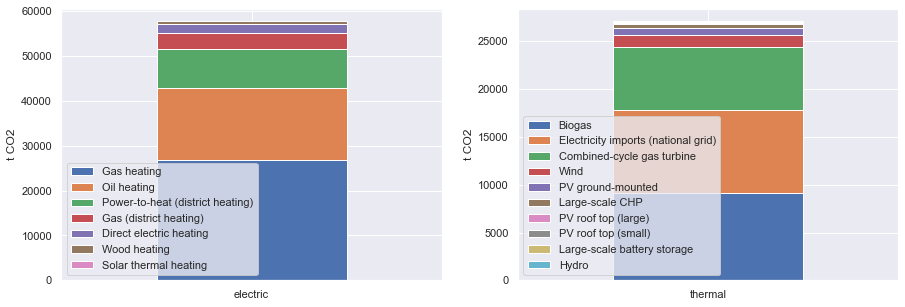

In [160]:
df_data_left = results_scns[scenario]['results_t']['CO2 emissions th. total'].rename('el').to_frame()
df_data_right = results_scns[scenario]['results_t']['CO2 emissions el. total'].rename('th').to_frame()

# drop nans & zeros
df_data_left = df_data_left[df_data_left!=0].dropna()
df_data_right = df_data_right[df_data_right!=0].dropna()

# sort values
df_data_left = df_data_left.sort_values(by='el', ascending=False)
df_data_right = df_data_right.sort_values(by='th', ascending=False)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

# left plot
df_data_left.T.plot(kind='bar', stacked=True, ax=ax1)
ax1.set_xticklabels(['electric'],rotation=0, ha='center')
ax1.set_ylabel('t CO2')

# right plot
df_data_right.T.plot(kind='bar', stacked=True, ax=ax2)
ax2.set_xticklabels(['thermal'], rotation=0, ha='center')
ax2.set_ylabel('t CO2')

plt.show()

In [352]:
df = df_data_left.join(df_data_right, how='outer')

fig = px.bar(df.T, orientation='h', title='CO2 Emissions')

fig.update_layout(barmode='stack', xaxis={'categoryorder':'total ascending'})
fig.update_xaxes(title_text='t CO2')
fig.update_yaxes(title_text='')
fig.show()

# 12, LCOE

## compare scenarios

In [416]:
val = 'LCOE'
df = pd.DataFrame([results_scns[sci]['results_t'][val] for sci in scenarios], index=scenarios)

df = df.rename(columns=PRINT_NAMES)

df = df.sort_values(by=scenarios, axis=1, ascending=True)

fig = px.bar(df, orientation='h', title=f'{val}')

fig.update_layout(barmode='stack', xaxis={'categoryorder':'total ascending'})
fig.update_xaxes(title_text='€/MWh')
fig.update_yaxes(title_text='')
fig.show()

## compare LCOE, LCOH

In [417]:
values = ['LCOE','LCOH']

df = pd.DataFrame([results_scns[scenario]['results_t'][i] for i in values], index=values)

df = df.rename(columns=PRINT_NAMES)

df = df.sort_values(by=values, axis=1, ascending=True)

fig = px.bar(df, orientation='h', title='LCOE and LCOH')

fig.update_layout(barmode='stack', xaxis={'categoryorder':'total ascending'})
fig.update_xaxes(title_text='€/MWh')
fig.update_yaxes(title_text='')
fig.show()

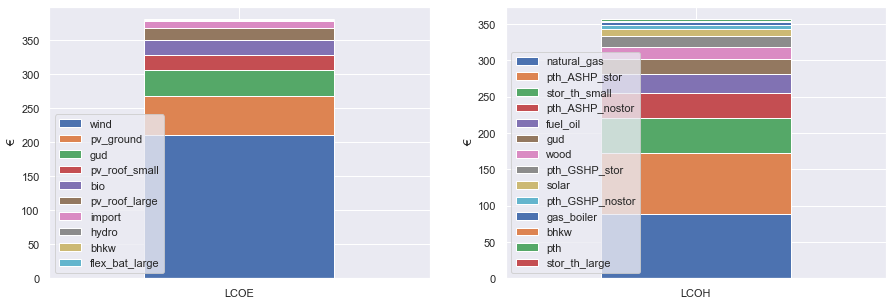

In [339]:
df_data_left = results_scns[scenario]['results_t']['LCOE'].rename('LCOE').to_frame()
df_data_right = results_scns[scenario]['results_t']['LCOH'].rename('LCOH').to_frame()

# drop nans & zeros
df_data_left = df_data_left[df_data_left!=0].dropna()
df_data_right = df_data_right[df_data_right!=0].dropna()

# sort values
df_data_left = df_data_left.sort_values(by='LCOE', ascending=False)
df_data_right = df_data_right.sort_values(by='LCOH', ascending=False)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

# left plot
df_data_left.T.plot(kind='bar', stacked=True, ax=ax1)
ax1.set_xticklabels(['LCOE'],rotation=0, ha='center')
ax1.set_ylabel('€')

# right plot
df_data_right.T.plot(kind='bar', stacked=True, ax=ax2)
ax2.set_xticklabels(['LCOH'], rotation=0, ha='center')
ax2.set_ylabel('€')

plt.show()

In [337]:
df_data

,LCOE
wind,210.706409
pv_ground,57.250664
gud,38.032274
pv_roof_small,22.378204
bio,21.934634
pv_roof_large,17.862745
import,9.365278
hydro,1.369241
bhkw,1.264904
flex_bat_large,0.384334


In [306]:
results_scns[scenario]['results_t']['LCOH']

bhkw                1.778607
coal                0.000000
elenergy            0.000000
fuel_oil           27.004219
gas_boiler          4.115031
gud                20.208822
natural_gas        88.349589
pth                 1.433138
pth_ASHP_nostor    34.651100
pth_ASHP_stor      84.835453
pth_GSHP_nostor     6.399071
pth_GSHP_stor      15.666692
solar               9.155808
wood               15.959166
stor_th_large       0.045123
stor_th_small      46.910303
dtype: float64

In [304]:
df = df_data_left.join(df_data_right, how='outer')

fig = px.bar(df.T, orientation='h', title='CO2 Emissions')

fig.update_layout(barmode='stack', xaxis={'categoryorder':'total ascending'})
fig.update_xaxes(title_text='t CO2')
fig.update_yaxes(title_text='')
fig.show()

# 9,10 Line Loadings

- Leitungskapazität? Um nach Auslastung zu schauen?

In [288]:
list(results_scns[scenario]['parameters'])

['Parameters el. generators',
 'Parameters th. generators',
 'Parameters storages',
 'Installierte Kapazität Großbatterien',
 'Installierte Kapazität PV-Batteriespeicher',
 'Installed capacity heat storage',
 'Installed capacity electricity supply',
 'Installed capacity heat supply']

In [290]:
# Timeseries
results_scns[scenario]['flows_txaxt']['Stromnetz']

out          in
timestamp           line_id     bus_from bus_to                          
2015-01-01 00:00:00 14261       15082301 15091241   40.785522   41.280893
                    14329       15001000 15001000    0.000000    0.000000
                    14351       15082301 15082440    0.000000    0.000000
                    14705       15082180 15082180    6.606487    6.686728
                    14716       15082005 15001000    0.000000    0.000000
...                                                       ...         ...
2015-01-31 23:00:00 24116       15082241 15091110   42.135303   42.647068
                    461202177   15091145 15091145    0.000000    0.000000
                    461202186   15091145 15091145 -156.174904 -158.071765
                    99999999990 15091145 15091145    0.000000    0.000000
                    99999999991 15091145 15091145 -158.071765 -159.991665

[55800 rows x 2 columns]

# 8 Flexibility

In [241]:
results_scns[scenario]['results_t'].keys()

dict_keys(['Electricity generation', 'Heat generation', 'CO2 emissions th. total', 'CO2 emissions el. total', 'Total costs electricity supply', 'Total costs heat supply', 'LCOE', 'LCOH'])

## Heatstorage

In [260]:
charge = results_scns[scenario]['results_axlxt']['Wärmespeicher nach Gemeinde'].loc[:,'charge']
discharge = results_scns[scenario]['results_axlxt']['Wärmespeicher nach Gemeinde'].loc[:,'discharge']
usage = discharge/charge

In [264]:
usage

level  ags     
cen    15001000    0.993752
       15082015    0.993892
       15082180    0.994271
       15091375    0.993091
dec    15001000    0.944907
       15082005    0.937734
       15082015    0.938415
       15082180    0.928173
       15082241    0.934001
       15082256    0.946160
       15082301    0.936559
       15082340    0.943728
       15082377    0.948983
       15082430    0.955794
       15082440    0.943421
       15091010    0.923515
       15091020    0.939989
       15091060    0.952687
       15091110    0.935912
       15091145    0.926412
       15091160    0.938840
       15091241    0.950530
       15091375    0.942247
       15091391    0.934503
dtype: float64

- ist usage überhaupt der Nutzungsgrad?
- Was heißt entladung?
- Gibt vermutlich auch eine Zeitliche Auflösung?!

In [303]:
# timeseries
results_scns[scenario]['flows_txaxt'].keys()

dict_keys(['Stromerzeugung', 'Wärmeerzeugung', 'Stromnachfrage', 'Wärmenachfrage', 'Stromexport', 'Stromimport', 'Wärmespeicher', 'Batteriespeicher', 'Stromnetz', 'Stromnachfrage Wärme', 'DSM activation'])

## Batterystorage

In [294]:
results_scns[scenario]['parameters']['Installierte Kapazität Großbatterien']

,capacity,power_charge,power_discharge
ags,,,
15001000,0.325650,3.452046,3.452046
15082005,0.019744,0.209292,0.209292
15082015,0.270235,2.864617,2.864617
15082180,0.108409,1.149189,1.149189
15082241,0.098370,1.042769,1.042769
15082256,0.131548,1.394476,1.394476
15082301,0.088047,0.933344,0.933344
15082340,0.192896,2.044784,2.044784
15082377,0.057304,0.607447,0.607447


- Batteriespeicher leer?

In [265]:
results_scns[scenario]['results_axlxt']['Batteriespeicher nach Gemeinde']

discharge    charge
level ags                          
large 15001000   0.000000  0.000000
      15082005   0.000000  0.000000
      15082015   0.000000  0.000000
      15082180   0.000000  0.000000
      15082241   0.000000  0.000000
      15082256   0.000000  0.000000
      15082301   0.000000  0.000000
      15082340   0.000000  0.000000
      15082377   0.000000  0.000000
      15082430   0.000000  0.000000
      15082440   0.000000  0.000000
      15091010   0.000000  0.000000
      15091020   0.000000  0.000000
      15091060   0.000000  0.000000
      15091110   0.000000  0.000000
      15091145   0.000000  0.000000
      15091160   0.000000  0.000000
      15091241   0.000000  0.000000
      15091375   0.000000  0.000000
      15091391   0.821216  0.943354

In [299]:
# timeseries
results_scns[scenario]['flows_txaxt']['Batteriespeicher']

,,,discharge,charge
timestamp,level,ags,,
2015-01-01 00:00:00,large,15001000,0.0,0.000000
2015-01-01 01:00:00,large,15001000,0.0,0.000000
2015-01-01 02:00:00,large,15001000,0.0,0.000000
2015-01-01 03:00:00,large,15001000,0.0,0.000000
2015-01-01 04:00:00,large,15001000,0.0,0.000000
...,...,...,...,...
2015-01-31 19:00:00,large,15091391,0.0,0.000000
2015-01-31 20:00:00,large,15091391,0.0,0.000000
2015-01-31 21:00:00,large,15091391,0.0,0.000000


- nur increase activation?

In [300]:
results_scns[scenario]['results_axlxt']['Stromnetzleitungen']

,,,out,in
line_id,bus_from,bus_to,,
14261,15082301,15091241,-32840.743274,-33239.618699
14329,15001000,15001000,592.411340,599.606619
14351,15082301,15082440,-331.093349,-335.114725
14705,15082180,15082180,7211.405745,7298.993669
14716,15082005,15001000,334.013663,338.070509
...,...,...,...,...
24116,15082241,15091110,1814.925522,1836.969151
461202177,15091145,15091145,0.000000,0.000000
461202186,15091145,15091145,-43052.165679,-43575.066477


## DSM

In [291]:
results_scns[scenario]['results_axlxt']['Net DSM activation']

ags
15001000    343.580056
15082005     39.243246
15082015    194.626511
15082180    127.244306
15082241     54.424853
15082256     40.846327
15082301     41.582583
15082340     62.596996
15082377     58.863676
15082430     90.847627
15082440     39.343392
15091010     32.939235
15091020     38.653325
15091060     53.187873
15091110     53.429409
15091145     57.766444
15091160     46.814989
15091241     39.659210
15091375    208.296005
15091391     41.232083
Name: Demand increase, dtype: float64

- nur increase activation?

In [282]:
results_scns[scenario]['flows_txaxt']['DSM activation']#['results_axlxt'].keys()

Demand increase  Demand decrease
timestamp           ags                                       
2015-01-01 00:00:00 15001000         0.000000         0.595740
                    15082005         0.000000         0.076805
                    15082015         0.000000         0.328412
                    15082180         0.000000         0.305939
                    15082241         0.000000         0.091368
...                                       ...              ...
2015-01-31 23:00:00 15091145         0.000000         0.123185
                    15091160         0.000000         0.116925
                    15091241         0.000000         0.081055
                    15091375         0.086709         0.260913
                    15091391         0.000000         0.082278

[14880 rows x 2 columns]

# inter ags elec transport / chord diagramm

- Plotly lässt sich nicht als bereits berechnetes HTML anzeigen / nur zur veranschaulichung
- -> Binder

#### Darstellung mit matplotlib

- Summe über Gemeinde als TS zusätzlich
- relativer Zeitliche Anteil Autarky
- mehrere Plots für ags?
- Summen über Tage?

- geoplot

## Access Windnode Database at RLI via VPN

In [ ]:
def postgres_session():
    """SQLAlchemy session object with valid connection to reeem database"""
    
    print('Please provide connection parameters to database:\n' +
              'Hit [Enter] to take defaults')
    host = '192.168.11.220'
    port = '54321'
    database = 'windnode_abw'
    user = 'windnode' 
    password = getpass.getpass(prompt='password: ', stream=sys.stderr)
#     password = 'windnode'
    con = create_engine(
            'postgresql://' + '%s:%s@%s:%s/%s' % (user,
                                                  password,
                                                  host,
                                                  port,
                                                  database)).connect()
    print('Password correct! Database connection established.')
    return con

# start session
con = postgres_session()
# get metadata
meta = MetaData(con, schema="windnode")

In [ ]:
# list of tables
tables_windnode_db = [i for i in meta.tables.keys()]
tables_windnode_db

### Plot all feed in ts

In [ ]:
# Database select (SQL)
table_name ='windnode.wn_abw_feedints'
sql = text("""SELECT * FROM {}""".format(table_name))
df_feedin = pd.read_sql_query(sql, con)
df_feedin = df_feedin.set_index('timestamp')

In [ ]:
df_feedin.head()

In [ ]:
df_feedin.index.value_counts().value_counts()

In [ ]:
# Facts dict
info_dict = {}
#info_dict['Filename'] = ['{}_windnode_db'.format(pd.to_datetime('today').strftime("%Y-%m-%d"))]
info_dict['Value'] = ['Leistung P']
info_dict['Unit'] = ['MW']
info_dict['Y-Axis'] = ['{} in {}'.format(*info_dict['Value'], *info_dict['Unit'])]
info_dict['X-Axis'] = ['Stunde im Jahr']
info_dict['Title'] = ['Feed in timeseries']
info_dict['Metadata'] = [meta_str]

In [ ]:
data = [go.Scatter(x=df_feedin.index.tolist(), 
               y=df_feedin[col].tolist(), 
               name=col, line=dict(), mode='lines') for col in df_feedin]

In [ ]:
layout = go.Layout(
    title=''.join(info_dict['Title']),
    yaxis=dict(title=''.join(info_dict['Y-Axis'])),
    xaxis=dict(title=''.join(info_dict['X-Axis']))
)
fig = go.Figure(data=data, layout=layout)
pltly.iplot(fig)